### **Описание датасета**

- **Предметная область:** Химический анализ красных вин и оценка их качества
- **Источник данных:** UCI Machine Learning Repository - реальные данные о винах Vinho Verde
- **Характер данных:** Реальные данные
- **Описание задачи:** Прогнозирование качества вина по химическим показателям

### **Описание атрибутов**

- **fixed acidity** - числовой - фиксированная кислотность (г/л винной кислоты)
- **volatile acidity** - числовой - летучая кислотность (г/л уксусной кислоты)
- **citric acid** - числовой - содержание лимонной кислоты (г/л)
- **residual sugar** - числовой - остаточный сахар (г/л)
- **chlorides** - числовой - содержание хлоридов (г/л хлорида натрия)
- **free sulfur dioxide** - числовой - свободный диоксид серы (мг/л)
- **total sulfur dioxide** - числовой - общий диоксид серы (мг/л)
- **density** - числовой - плотность (г/мл)
- **pH** - числовой - уровень кислотности
- **sulphates** - числовой - содержание сульфатов (г/л сульфата калия)
- **alcohol** - числовой - содержание алкоголя (% об.)
- **quality** - числовой - качество вина (шкала от 0 до 10)

### **Новый атрибут**
- **total acidity** - числовой - общая кислотность

### **Ход работы:**

#### **Импорт библиотек и загрузка датасета**

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
from tabulate import tabulate
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, confusion_matrix, classification_report,
                           roc_curve, auc, roc_auc_score, RocCurveDisplay)
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10


path = "/Users/yulia/Desktop/вуз/winequality-red.csv"



with open(path, 'r') as f:
    first_lines = [f.readline().strip() for _ in range(5)]

print("Первые строки файла:")
for i, line in enumerate(first_lines):
    print(f"{i}: {line}")


first_line = first_lines[0]
df = pd.read_csv(path, sep=',')

num_columns = len(df.columns)
split_index = num_columns // 3
print("Первые 5 строк :")
first_half = df.iloc[:, :split_index]
print(tabulate(first_half.head(), headers='keys', tablefmt='grid', floatfmt=".2f"))
print("\n\n")

second_half = df.iloc[:, split_index:]
print(tabulate(second_half.head(), headers='keys', tablefmt='grid', floatfmt=".2f"))


Первые строки файла:
0: fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1: 7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
2: 7.8,0.88,0.0,2.6,0.098,25.0,67.0,0.9968,3.2,0.68,9.8,5
3: 7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.997,3.26,0.65,9.8,5
4: 11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.998,3.16,0.58,9.8,6
Первые 5 строк :
+----+-----------------+--------------------+---------------+------------------+
|    |   fixed acidity |   volatile acidity |   citric acid |   residual sugar |
+====+=================+====================+===============+==================+
|  0 |            7.40 |               0.70 |          0.00 |             1.90 |
+----+-----------------+--------------------+---------------+------------------+
|  1 |            7.80 |               0.88 |          0.00 |             2.60 |
+----+-----------------+--------------------+---------------+------------------+
|  2 |     

### **Выбор целевого класса**
Во время анализа на пригодность были проверены следующие атрибуты:
- quality - качество
- fixed acidity - кислотность
- alcohol - содержание алкоголя

In [17]:
print("1. Quality (категориальный):")
print(f"Уникальных значений качества: {df['quality'].nunique()}")
print("Распределение по качеству:")
print(df['quality'].value_counts().sort_index())
print(f"Тип данных: {df['quality'].dtype}")
print()

print("2. Fixed acidity (числовой):")
print(f"Уникальных значений: {df['fixed acidity'].nunique()}")
print("Распределение (топ-5 наиболее частых значений):")
print(df['fixed acidity'].value_counts().head())
print(f"Тип данных: {df['fixed acidity'].dtype}")
print()

print("3. Alcohol (числовой):")
print(f"Уникальных значений: {df['alcohol'].nunique()}")
print("Распределение (топ-5 наиболее частых значений):")
print(df['alcohol'].value_counts().head())
print(f"Тип данных: {df['alcohol'].dtype}")

1. Quality (категориальный):
Уникальных значений качества: 6
Распределение по качеству:
quality
3     10
4     53
5    681
6    638
7    199
8     18
Name: count, dtype: int64
Тип данных: int64

2. Fixed acidity (числовой):
Уникальных значений: 96
Распределение (топ-5 наиболее частых значений):
fixed acidity
7.2    67
7.1    57
7.8    53
7.5    52
7.0    50
Name: count, dtype: int64
Тип данных: float64

3. Alcohol (числовой):
Уникальных значений: 65
Распределение (топ-5 наиболее частых значений):
alcohol
9.5     139
9.4     103
9.8      78
9.2      72
10.0     67
Name: count, dtype: int64
Тип данных: float64


### **Оценка сбалансированности класса**

**Для оценки сбалансированности возьмем за основой целевой класс атрибут quality**

In [19]:
def analyze_multiclass_balance(series, target_name):
    counts = series.value_counts()
    percentages = series.value_counts(normalize=True) * 100

    for value, count in counts.items():
        print(f"Качество {value}: {count} записей ({percentages[value]:.1f}%)")

    imbalance_ratio = counts.max() / counts.min()
    std_percentage = percentages.std()

    print(f"\nКоэффициент дисбаланса: {imbalance_ratio:.2f}")
    print(f"Стандартное отклонение распределения: {std_percentage:.2f}%")

    if imbalance_ratio < 3:
        print("Хорошо сбалансированные классы")
    elif imbalance_ratio < 8:
        print("Умеренный дисбаланс")
    else:
        print("Сильный дисбаланс")

    return imbalance_ratio, std_percentage

if 'quality' in df.columns:
    quality_imbalance, quality_std = analyze_multiclass_balance(df['quality'], 'Качество вина')

Качество 5: 681 записей (42.6%)
Качество 6: 638 записей (39.9%)
Качество 7: 199 записей (12.4%)
Качество 4: 53 записей (3.3%)
Качество 8: 18 записей (1.1%)
Качество 3: 10 записей (0.6%)

Коэффициент дисбаланса: 68.10
Стандартное отклонение распределения: 19.53%
Сильный дисбаланс


### **Сравнение алгоритмов классификации: kNN и дерево решений**
**Предобработка данных для классификации по атрибуту quality**

In [20]:
features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
           'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
           'pH', 'sulphates', 'alcohol']

df_clean = df[features + ['quality']].dropna()

X = df_clean[features]
y = df_clean['quality']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = train_test_split(
    X_scaled, y_encoded,
    test_size=0.3,
    random_state=42,
    stratify=y_encoded
)

print(f"Обучающая выборка (X_train): {X_train.shape}")
print(f"Тестовая выборка (X_test): {X_test.shape}")
print(f"Обучающие метки (y_train): {y_train.shape}")
print(f"Тестовые метки (y_test): {y_test.shape}")
print(f"Уникальные классы качества: {np.unique(y)}")

Обучающая выборка (X_train): (1119, 11)
Тестовая выборка (X_test): (480, 11)
Обучающие метки (y_train): (1119,)
Тестовые метки (y_test): (480,)
Уникальные классы качества: [3 4 5 6 7 8]


### **Алгоритм kNN**


Оптимальное количество соседей: k = 1


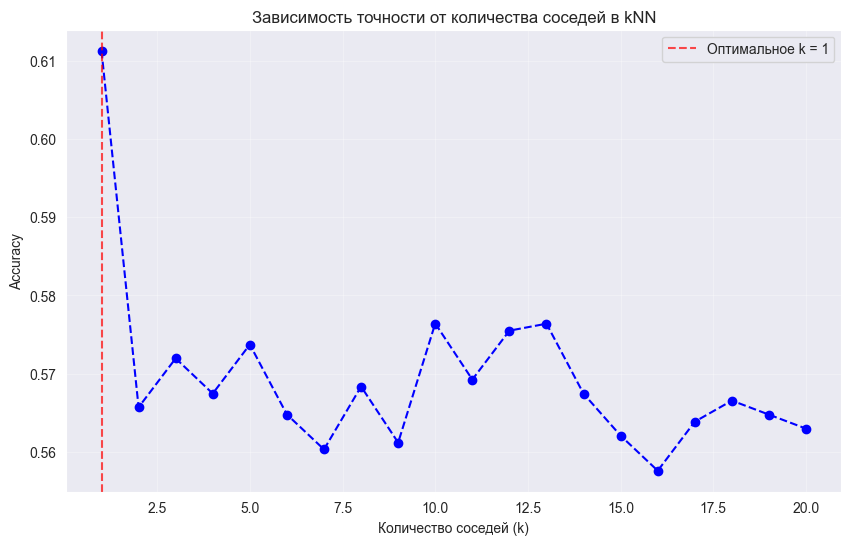

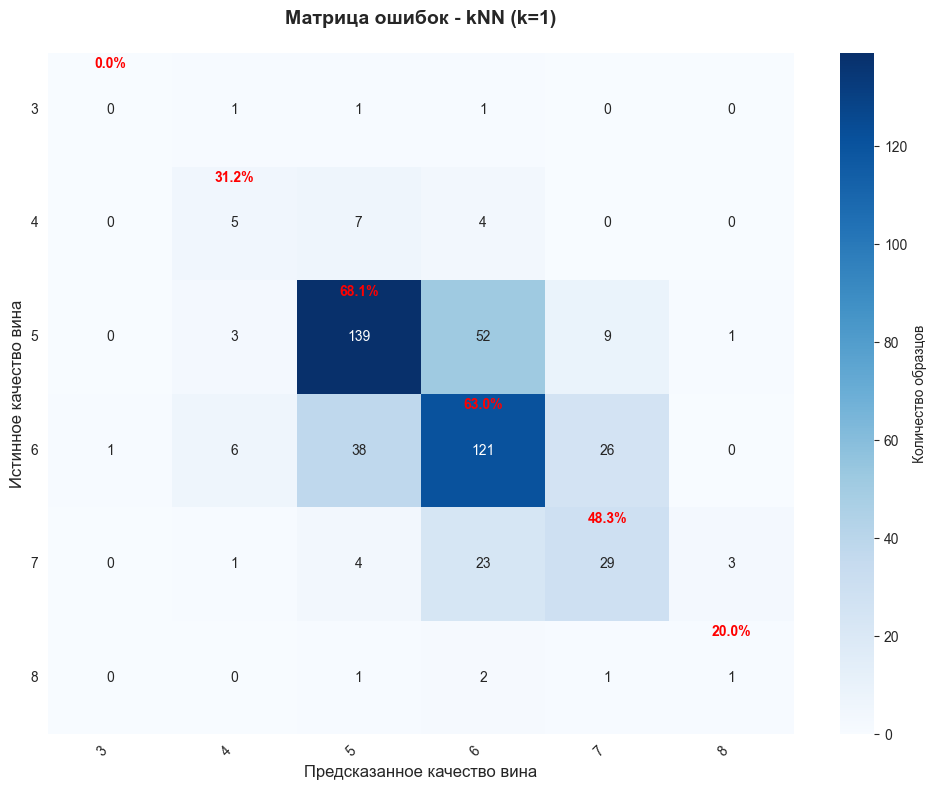


Метрики kNN (k=1):
Accuracy: 0.615
Precision (macro): 0.381
Recall (macro): 0.385
F1-score (macro): 0.382


In [21]:
k_range = range(1, 21)
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_encoded, y_train_encoded, cv=5, scoring='accuracy')
    k_scores.append(scores.mean())

optimal_k = k_range[np.argmax(k_scores)]

print(f"Оптимальное количество соседей: k = {optimal_k}")

plt.figure(figsize=(10, 6))
plt.plot(k_range, k_scores, marker='o', linestyle='--', color='blue')
plt.axvline(x=optimal_k, color='red', linestyle='--', alpha=0.7, label=f'Оптимальное k = {optimal_k}')
plt.xlabel('Количество соседей (k)')
plt.ylabel('Accuracy')
plt.title('Зависимость точности от количества соседей в kNN')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train_encoded, y_train_encoded)

y_pred_knn = knn.predict(X_test_encoded)
cm_knn = confusion_matrix(y_test_encoded, y_pred_knn)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues',
           xticklabels=label_encoder.classes_,
           yticklabels=label_encoder.classes_,
           cbar_kws={'label': 'Количество образцов'})

plt.title(f'Матрица ошибок - kNN (k={optimal_k})\n', fontsize=14, fontweight='bold')
plt.ylabel('Истинное качество вина', fontsize=12)
plt.xlabel('Предсказанное качество вина', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

for i in range(len(cm_knn)):
    accuracy = cm_knn[i,i] / cm_knn[i].sum() if cm_knn[i].sum() > 0 else 0
    plt.text(i + 0.5, i + 0.1, f'{accuracy:.1%}',
             ha='center', va='center', fontweight='bold', color='red')

plt.tight_layout()
plt.show()

print(f"\nМетрики kNN (k={optimal_k}):")
print(f"Accuracy: {accuracy_score(y_test_encoded, y_pred_knn):.3f}")
print(f"Precision (macro): {precision_score(y_test_encoded, y_pred_knn, average='macro'):.3f}")
print(f"Recall (macro): {recall_score(y_test_encoded, y_pred_knn, average='macro'):.3f}")
print(f"F1-score (macro): {f1_score(y_test_encoded, y_pred_knn, average='macro'):.3f}")

### **Алгоритм дерева решений**

Лучшие параметры: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 8, 'min_samples_split': 2}
Лучшая accuracy при кросс-валидации: 0.5961
Accuracy на тестовой выборке: 0.5646
Precision (macro): 0.2714
Recall (macro): 0.2467
F1-score (macro): 0.2439


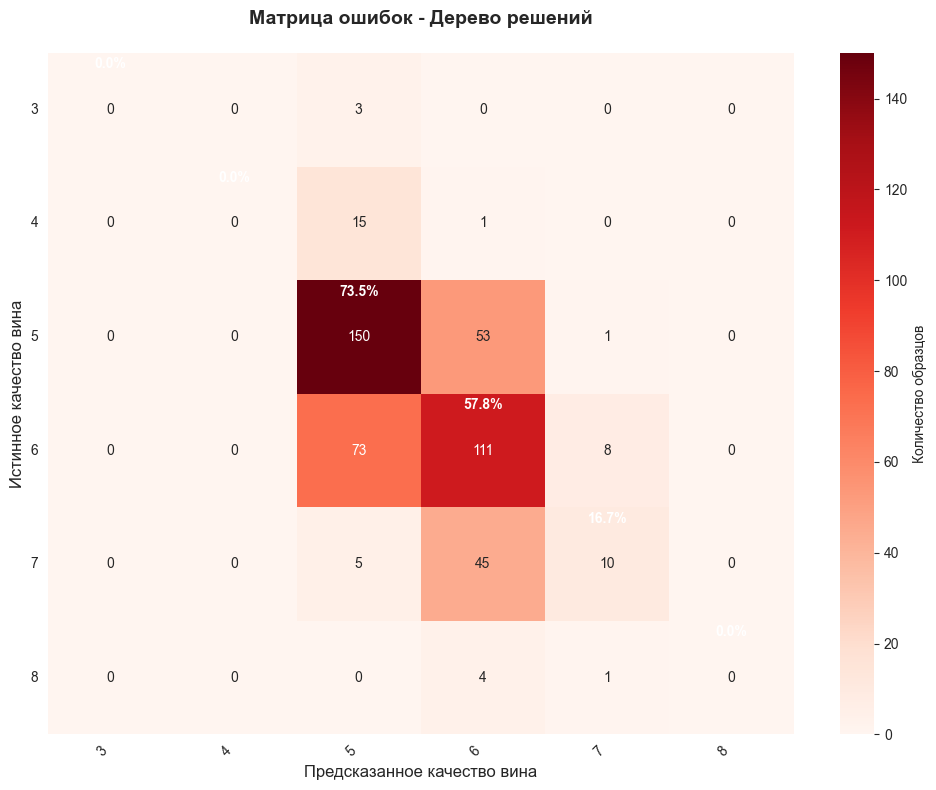

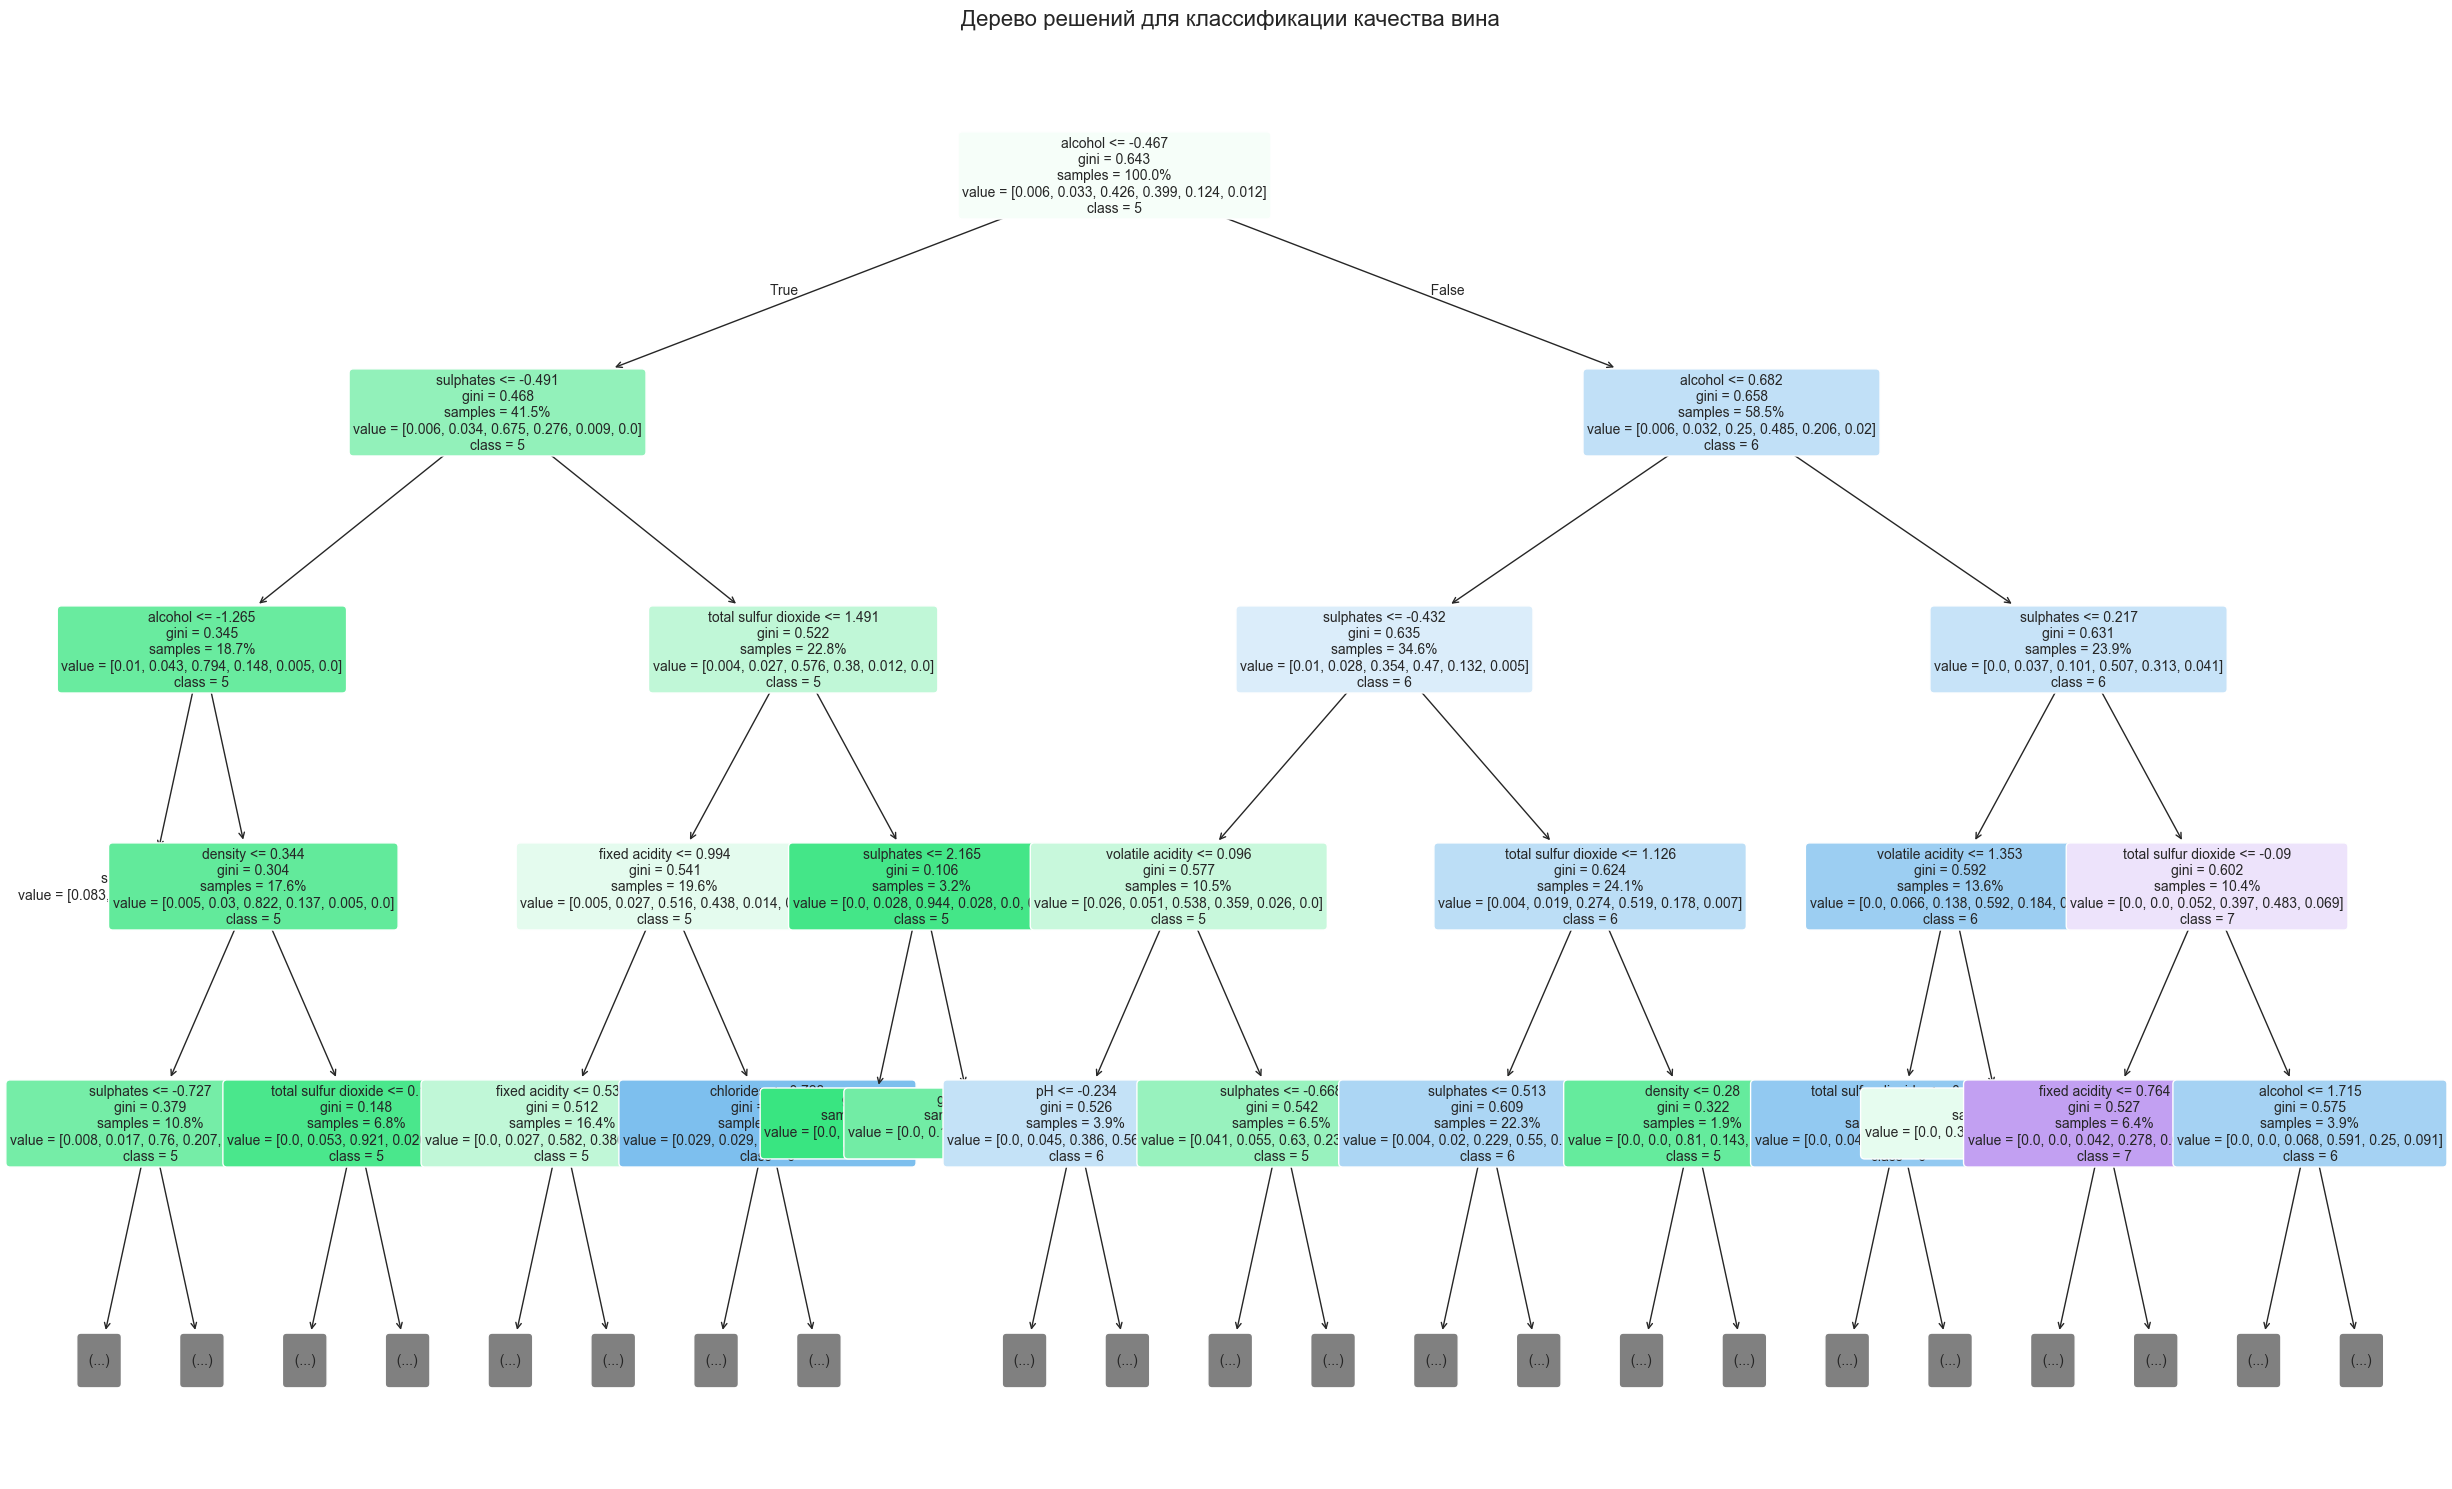


Важность признаков в дереве решений:
                 feature  importance
10               alcohol    0.446561
9              sulphates    0.194822
6   total sulfur dioxide    0.162524
0          fixed acidity    0.101574
1       volatile acidity    0.048198
7                density    0.022832
8                     pH    0.014693
4              chlorides    0.008797
2            citric acid    0.000000
5    free sulfur dioxide    0.000000
3         residual sugar    0.000000


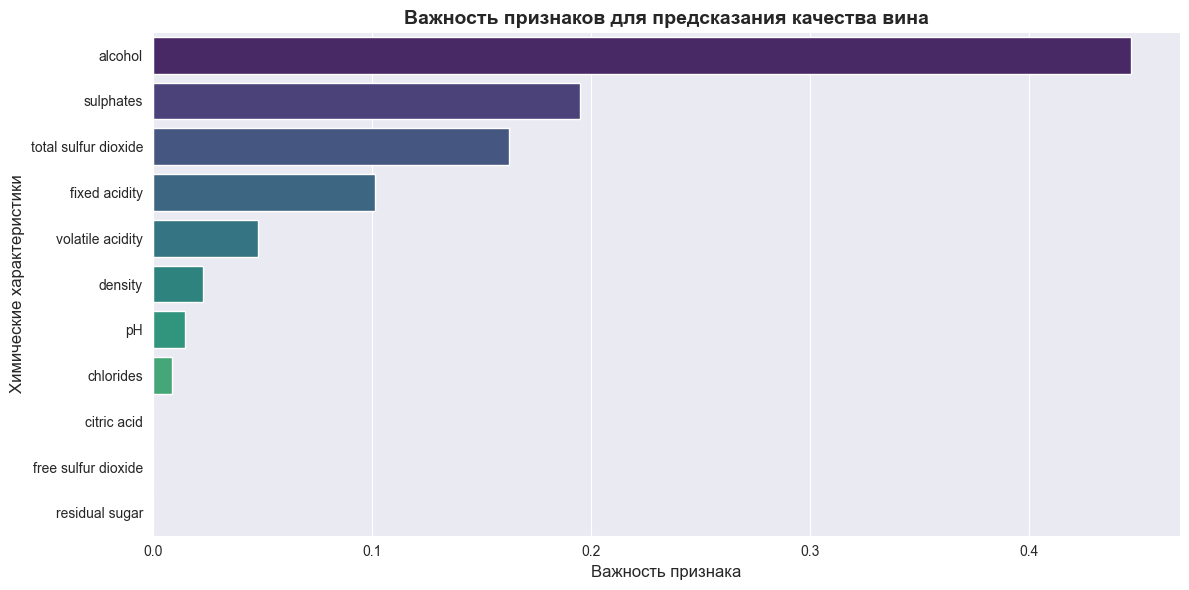

In [22]:
param_grid = {
    'max_depth': [3, 5, 7, 10, 15, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini', 'entropy']
}

dt = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_encoded, y_train_encoded)

print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучшая accuracy при кросс-валидации: {grid_search.best_score_:.4f}")

dt_best = grid_search.best_estimator_
dt_best.fit(X_train_encoded, y_train_encoded)
y_pred_dt = dt_best.predict(X_test_encoded)
y_prob_dt = dt_best.predict_proba(X_test_encoded)

print(f"Accuracy на тестовой выборке: {accuracy_score(y_test_encoded, y_pred_dt):.4f}")
print(f"Precision (macro): {precision_score(y_test_encoded, y_pred_dt, average='macro'):.4f}")
print(f"Recall (macro): {recall_score(y_test_encoded, y_pred_dt, average='macro'):.4f}")
print(f"F1-score (macro): {f1_score(y_test_encoded, y_pred_dt, average='macro'):.4f}")

cm_dt = confusion_matrix(y_test_encoded, y_pred_dt)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Reds',
           xticklabels=label_encoder.classes_,
           yticklabels=label_encoder.classes_,
           cbar_kws={'label': 'Количество образцов'})

plt.title(f'Матрица ошибок - Дерево решений\n', fontsize=14, fontweight='bold')
plt.ylabel('Истинное качество вина', fontsize=12)
plt.xlabel('Предсказанное качество вина', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

for i in range(len(cm_dt)):
    accuracy = cm_dt[i,i] / cm_dt[i].sum() if cm_dt[i].sum() > 0 else 0
    plt.text(i + 0.5, i + 0.1, f'{accuracy:.1%}',
             ha='center', va='center', fontweight='bold', color='white')

plt.tight_layout()
plt.show()

plt.figure(figsize=(25, 15))
plot_tree(dt_best,
          feature_names=features,
          class_names=[str(cls) for cls in label_encoder.classes_],
          filled=True,
          rounded=True,
          fontsize=10,
          proportion=True,
          max_depth=4)

plt.title('Дерево решений для классификации качества вина\n', fontsize=16)
plt.tight_layout()
plt.show()

feature_importance = pd.DataFrame({
    'feature': features,
    'importance': dt_best.feature_importances_
}).sort_values('importance', ascending=False)

print("\nВажность признаков в дереве решений:")
print(feature_importance)

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')
plt.title('Важность признаков для предсказания качества вина', fontsize=14, fontweight='bold')
plt.xlabel('Важность признака', fontsize=12)
plt.ylabel('Химические характеристики', fontsize=12)
plt.tight_layout()
plt.show()

### **Сравнение результатов классификации**

#### **Сравнение метрик классификации: kNN vs Дерево решений**


Сравнение метрик классификации качества вина:


,Metric,kNN,Decision Tree
0,Accuracy,0.614583,0.564583
1,Precision (macro),0.381049,0.271408
2,Recall (macro),0.384569,0.246681
3,F1-score (macro),0.382457,0.243911



Разница в метриках (kNN - Decision Tree):
              Metric  Difference
0           Accuracy    0.050000
1  Precision (macro)    0.109641
2     Recall (macro)    0.137888
3   F1-score (macro)    0.138546


<Figure size 1200x600 with 0 Axes>

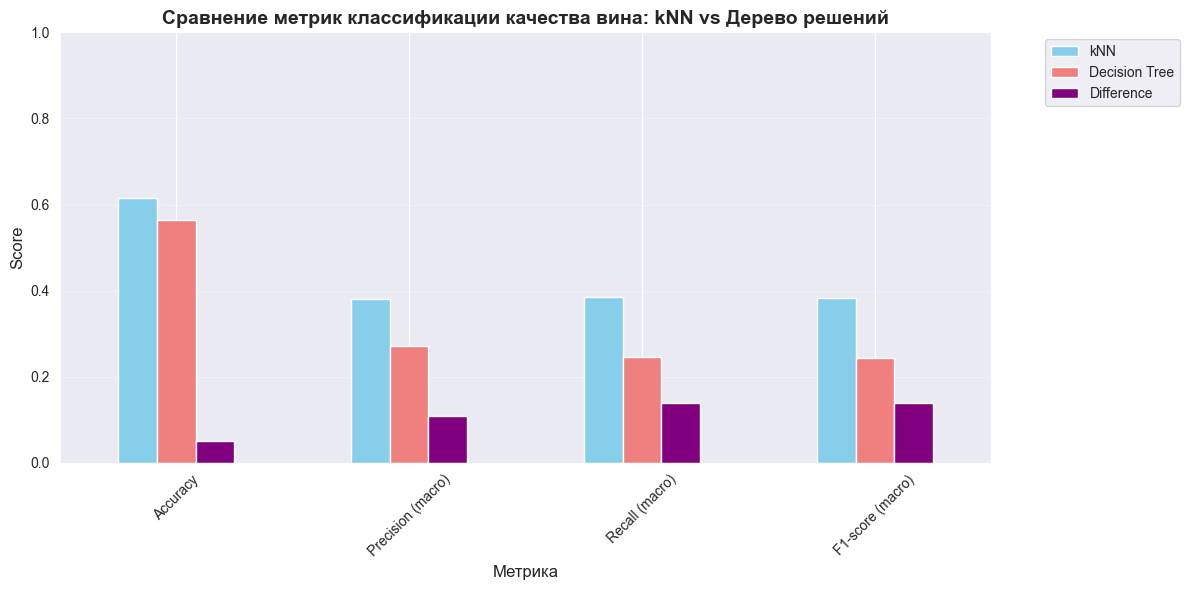



Сравнение по классам:

Отчет классификации для kNN:
              precision    recall  f1-score   support

  Качество 3       0.00      0.00      0.00         3
  Качество 4       0.31      0.31      0.31        16
  Качество 5       0.73      0.68      0.71       204
  Качество 6       0.60      0.63      0.61       192
  Качество 7       0.45      0.48      0.46        60
  Качество 8       0.20      0.20      0.20         5

    accuracy                           0.61       480
   macro avg       0.38      0.38      0.38       480
weighted avg       0.62      0.61      0.62       480


Отчет классификации для Decision Tree:
              precision    recall  f1-score   support

  Качество 3       0.00      0.00      0.00         3
  Качество 4       0.00      0.00      0.00        16
  Качество 5       0.61      0.74      0.67       204
  Качество 6       0.52      0.58      0.55       192
  Качество 7       0.50      0.17      0.25        60
  Качество 8       0.00      0.00     

In [23]:
metrics_comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision (macro)', 'Recall (macro)', 'F1-score (macro)'],
    'kNN': [
        accuracy_score(y_test_encoded, y_pred_knn),
        precision_score(y_test_encoded, y_pred_knn, average='macro'),
        recall_score(y_test_encoded, y_pred_knn, average='macro'),
        f1_score(y_test_encoded, y_pred_knn, average='macro')
    ],
    'Decision Tree': [
        accuracy_score(y_test_encoded, y_pred_dt),
        precision_score(y_test_encoded, y_pred_dt, average='macro'),
        recall_score(y_test_encoded, y_pred_dt, average='macro'),
        f1_score(y_test_encoded, y_pred_dt, average='macro')
    ]
})

print("Сравнение метрик классификации качества вина:")

display(metrics_comparison)

metrics_comparison['Difference'] = metrics_comparison['kNN'] - metrics_comparison['Decision Tree']
print("\nРазница в метриках (kNN - Decision Tree):")
print(metrics_comparison[['Metric', 'Difference']])

plt.figure(figsize=(12, 6))
metrics_comparison.set_index('Metric').plot(kind='bar', figsize=(12, 6),
                                          color=['skyblue', 'lightcoral', 'purple'])
plt.title('Сравнение метрик классификации качества вина: kNN vs Дерево решений',
          fontsize=14, fontweight='bold')
plt.ylabel('Score', fontsize=12)
plt.xlabel('Метрика', fontsize=12)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

print("\n")
print("Сравнение по классам:")


print("\nОтчет классификации для kNN:")
print(classification_report(y_test_encoded, y_pred_knn,
                           target_names=[f'Качество {cls}' for cls in label_encoder.classes_]))

print("\nОтчет классификации для Decision Tree:")
print(classification_report(y_test_encoded, y_pred_dt,
                           target_names=[f'Качество {cls}' for cls in label_encoder.classes_]))

best_algorithm = 'kNN' if metrics_comparison['kNN'].mean() > metrics_comparison['Decision Tree'].mean() else 'Decision Tree'
print(f"\nЛучший алгоритм по среднему значению метрик: {best_algorithm}")
print(f"Средняя метрика kNN: {metrics_comparison['kNN'].mean():.4f}")
print(f"Средняя метрика Decision Tree: {metrics_comparison['Decision Tree'].mean():.4f}")

 ### **Построение ROC-кривых для мультиклассовой классификации: kNN и Дерево решений**

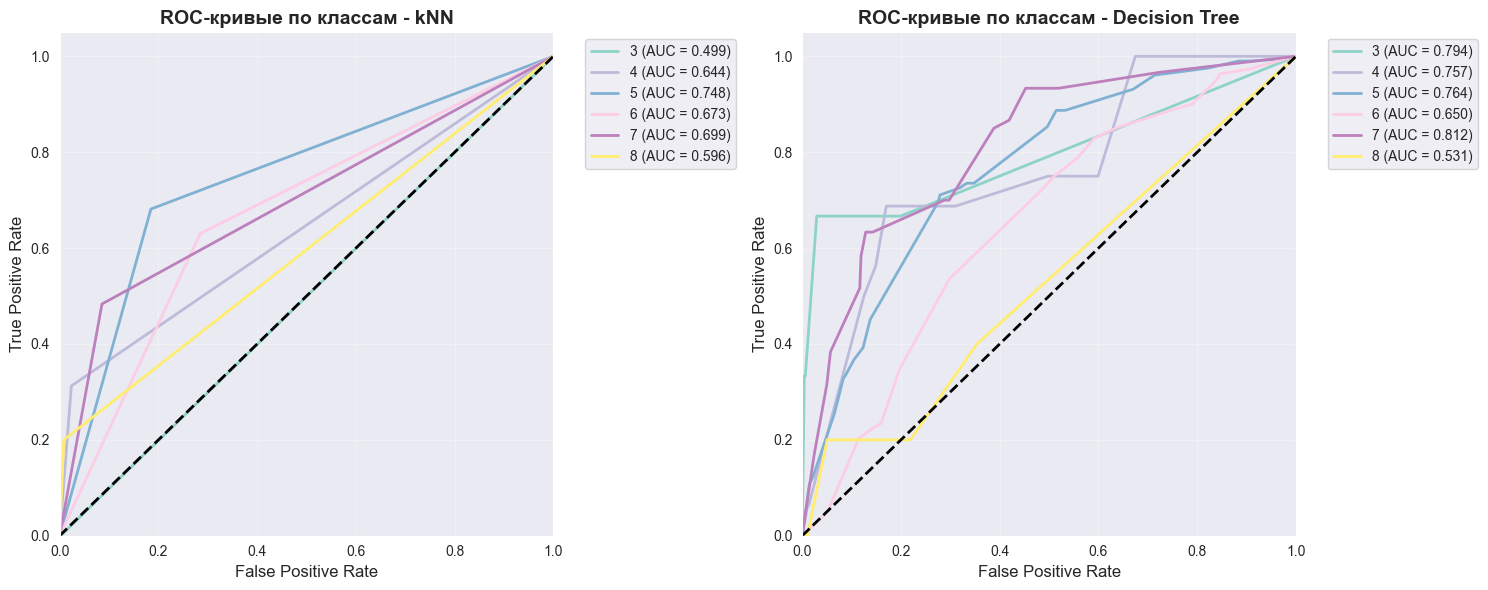

In [24]:
y_test_bin = label_binarize(y_test_encoded, classes=range(len(label_encoder.classes_)))
n_classes = y_test_bin.shape[1]

y_prob_knn = knn.predict_proba(X_test_encoded)
y_prob_dt = dt_best.predict_proba(X_test_encoded)

fpr_knn = dict()
tpr_knn = dict()
roc_auc_knn = dict()

fpr_dt = dict()
tpr_dt = dict()
roc_auc_dt = dict()

for i in range(n_classes):
    fpr_knn[i], tpr_knn[i], _ = roc_curve(y_test_bin[:, i], y_prob_knn[:, i])
    roc_auc_knn[i] = auc(fpr_knn[i], tpr_knn[i])

    fpr_dt[i], tpr_dt[i], _ = roc_curve(y_test_bin[:, i], y_prob_dt[:, i])
    roc_auc_dt[i] = auc(fpr_dt[i], tpr_dt[i])

fpr_knn["micro"], tpr_knn["micro"], _ = roc_curve(y_test_bin.ravel(), y_prob_knn.ravel())
roc_auc_knn["micro"] = auc(fpr_knn["micro"], tpr_knn["micro"])

fpr_dt["micro"], tpr_dt["micro"], _ = roc_curve(y_test_bin.ravel(), y_prob_dt.ravel())
roc_auc_dt["micro"] = auc(fpr_dt["micro"], tpr_dt["micro"])

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
colors = plt.cm.Set3(np.linspace(0, 1, n_classes))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_knn[i], tpr_knn[i], color=color, lw=2,
             label='{0} (AUC = {1:0.3f})'.format(label_encoder.classes_[i], roc_auc_knn[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC-кривые по классам - kNN', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_dt[i], tpr_dt[i], color=color, lw=2,
             label='{0} (AUC = {1:0.3f})'.format(label_encoder.classes_[i], roc_auc_dt[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC-кривые по классам - Decision Tree', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### **Анализ данных:**

Алгоритм k-ближайших соседей (kNN) показал лучшие результаты по всем метрикам классификации качества вина.

Преимущества kNN особенно заметны в:

- общей точности предсказаний качества;

- сбалансированности между precision и recall;

- способности различать все градации качества вина.

Дерево решений, несмотря на хорошие результаты, уступило kNN по ключевым показателям. Это объясняется природой данных: химические характеристики вина образуют плавные переходы между классами качества, что лучше соответствует метрическому подходу kNN. Жесткие границы решений в дереве хуже отражают непрерывный характер зависимости качества от химического состава.